<a href="https://colab.research.google.com/github/adhello007/PersonalProjects-DeepLearning/blob/main/Anime_WGAN_ScratchImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

import tensorflow as tf
from keras.layers import Layer, Conv2D, Conv2DTranspose, Activation, Reshape, LayerNormalization, BatchNormalization
from keras.layers import Input, Dropout, Concatenate, Dense, LeakyReLU, Flatten
from keras import Model
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.initializers import RandomNormal
from keras.utils import plot_model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive')

In [ ]:
#!unzip animefaces.zip

In [ ]:
#store paths of images into a list
image_path = "anime faces/cropped"
images = [os.path.join(image_path, i) for i in os.listdir(image_path)]

In [ ]:
#defining essential variables

MODEL_NAME = 'WGAN'
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.


TARGET_IMG_SIZE = 64 # Scale img to dis size
BATCH_SIZE = 128
NOISE_DIM = 100
LAMBDA = 10 # For grad penalty

EPOCHs = 40
CURRENT_EPOCH = 1 # Epoch sstart from
SAVE_EVERY_N_EPOCH = 15 # Save checkpoint at every 15 eposchs

N_CRITIC = 3 # Train critic 3 times then train gene 1 tim.
LR = 1e-4
MIN_LR = 0.000001 # min value of lr rate.
DECAY_FACTOR=1.00004 # learning rate decay factor


file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR) #Creaetin a file writeter for the log diorectory.

In [ ]:
#convert the datasset list to tensorflow dataset type to load it

list_ds = tf.data.Dataset.list_files("anime faces/cropped/*")
for f in list_ds.take(5):
  print(f.numpy())
  print(type(f))

b'anime faces/cropped/41377_2013.jpg'
<class 'tensorflow.python.framework.ops.EagerTensor'>
b'anime faces/cropped/53103_2016.jpg'
<class 'tensorflow.python.framework.ops.EagerTensor'>
b'anime faces/cropped/59437_2018.jpg'
<class 'tensorflow.python.framework.ops.EagerTensor'>
b'anime faces/cropped/59905_2018.jpg'
<class 'tensorflow.python.framework.ops.EagerTensor'>
b'anime faces/cropped/42123_2013.jpg'
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
#normalize the dataset
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5 #makes it -1 to 1
    return image

def preprocess_image(file_path):
    images = tf.io.read_file(file_path) #images variable contains the binary data of the file specified by file_path.

    images = tf.image.decode_jpeg(images, channels=3) #It takes the binary image data as input and decodes it into a 3D tensor of shape
    images = tf.image.resize(images, (TARGET_IMG_SIZE, TARGET_IMG_SIZE),
                           method='bicubic', antialias=True) #bicubic interpolation
    images = normalize(images)
    return images

In [ ]:
#now lets map the dataset into preprcosesded functions and load it in defined batches
train_data = list_ds.map(preprocess_image).shuffle(1000).batch(BATCH_SIZE) #1000 is the buffer size for shuffling


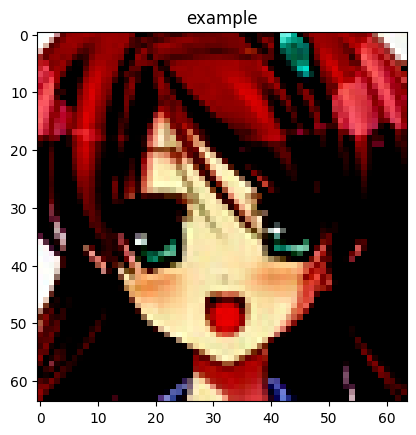

In [ ]:
sample_img  = next(iter(train_data))
plt.title("example")
plt.imshow(np.clip(sample_img[0],0,1)) #min and ma value of clippin

LETS START MAKING THE MODDEL

In [ ]:
#create the generator
#using a DCGAN architechutree
def GAN_generator(input_z_shape=NOISE_DIM):

    input_z_layer = Input(input_z_shape)

    z = Dense(4*4*512, use_bias=False)(input_z_layer)
    z =Reshape((4, 4, 512))(z) #reshape layer

    x = Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(z)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    output = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh",
                             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)

    model = Model(inputs=input_z_layer, outputs=output) #stacked llayers in the model
    return model



In [ ]:
#create the discriminator (criti)
def GAN_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)):

    input_x_layer = Input(input_x_shape)

    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_x_layer)
    x = LeakyReLU()(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = Flatten()(x)

    output = Dense(1)(x)

    model = Model(inputs=input_x_layer, outputs=output) #stacked it in a model
    return model

In [ ]:
#now initialize the gen and disc
generator = GAN_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 8192)              819200    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         4194304   
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 4, 4, 512)         2048      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4, 4, 512)         0     

In [ ]:
discriminator = GAN_discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524288    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 256)         0   

In [ ]:
#define optimizeer and learning rates for the bboth
# optim
D_optimizer = Adam(learning_rate=LR, beta_1=0.5)
G_optimizer = Adam(learning_rate=LR, beta_1=0.5)

def learning_rate_decay(current_lr, decay_factor=DECAY_FACTOR): #calc a new lr
    new_lr = max(current_lr / decay_factor, MIN_LR)
    return new_lr

def set_learning_rate(new_lr): #set lr to optimizers
    K.set_value(D_optimizer.lr, new_lr)
    K.set_value(G_optimizer.lr, new_lr) #k is the keras backend api



In [ ]:
#now lets create a checkpoint to save checkpoints in case training stops
#so that you dont have to train from scratch

checkpoint_path = os.path.join("checkpoints", "tensorflow", MODEL_NAME)

ckpt = tf.train.Checkpoint(generator=generator, #object created
                              discriminator=discriminator,
                            G_optimizer=G_optimizer,
                           D_optimizer=D_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint. When the number of checkpoints exceeds this limit, older checkpoints will be deleted automatically.
#stackoverflow code section
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

In [ ]:
#NOW lets create a sample function for creating and plotting a figure on a partciular epoch
def generate_and_save_images(model, epoch, test_input, figure_size=(12,6), subplot=(3,6), save=True, is_flatten=False):
    predictions = model.predict(test_input)
    if is_flatten:
        predictions = predictions.reshape(-1, TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3).astype('float32')
    fig = plt.figure(figsize=figure_size)
    for i in range(predictions.shape[0]):
        axs = plt.subplot(subplot[0], subplot[1], i+1)
        plt.imshow(predictions[i] * 0.5 + 0.5)
        plt.axis('off') #removes axis lines
    if save:
        plt.savefig(os.path.join("output", 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

FINALLY TRAINING FUCNTIONS OF THE NETWORK

In [ ]:
@tf.function
def train_d_step(real_image, batch_size, step):
    #https://www.tensorflow.org/tutorials/generative/dcgan  - if youre lost
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    #epsilon will interpolate bw real n fake img, make sure lishizts cont is maintained

    #train disc
    with tf.GradientTape(persistent=True) as d_tape: #persistent=True allows the tape to be used multiple time.
        with tf.GradientTape() as gp_tape: # This inner tape is used to compute gradients with respect to the fake_image_mixed tensor.
            fake_image = generator([noise], training=True)
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            fake_mixed_pred = discriminator([fake_image_mixed], training=True)

        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        #compute the gradients for pred on the fake  image with respect to the pred on mized image
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
        #the gradf penalty term encourages the norm of the gradients to be close to 1.
        fake_pred = discriminator([fake_image], training=True)
        real_pred = discriminator([real_image], training=True)

        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss,
                                            discriminator.trainable_variables) #training vars are weights and biases

    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))
    # Write loss values to tensorboard
    #if step % 10 == 0:
        #with file_writer.as_default():
            #tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)


In [ ]:

@tf.function
def train_g_step(real_image, batch_size, step):
    #https://www.tensorflow.org/tutorials/generative/dcgan

    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
   #train G
    with tf.GradientTape() as g_tape:
        fake_image = generator([noise], training=True)
        fake_pred = discriminator([fake_image], training=True)
        G_loss = -tf.reduce_mean(fake_pred)
    # Calculate the grads for gen
    G_gradients = g_tape.gradient(G_loss,
                                            generator.trainable_variables)
    # Apply the grad to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients,
                                                generator.trainable_variables))
    # Write loss values to tensorboard
    #if step % 10 == 0:
      #  with file_writer.as_default():
      #     tf.summary.scalar('G_loss', G_loss, step=step)

START THE TRAINING NOW

In [ ]:
current_learning_rate = LR
trace = True #clear output and have space for another
n_critic_count = 0 #no of times to rtrain the disc before training one iter of g

In [ ]:
sample_noise = tf.random.normal([18, NOISE_DIM])

1/1 [==============================] - 0s 16ms/step


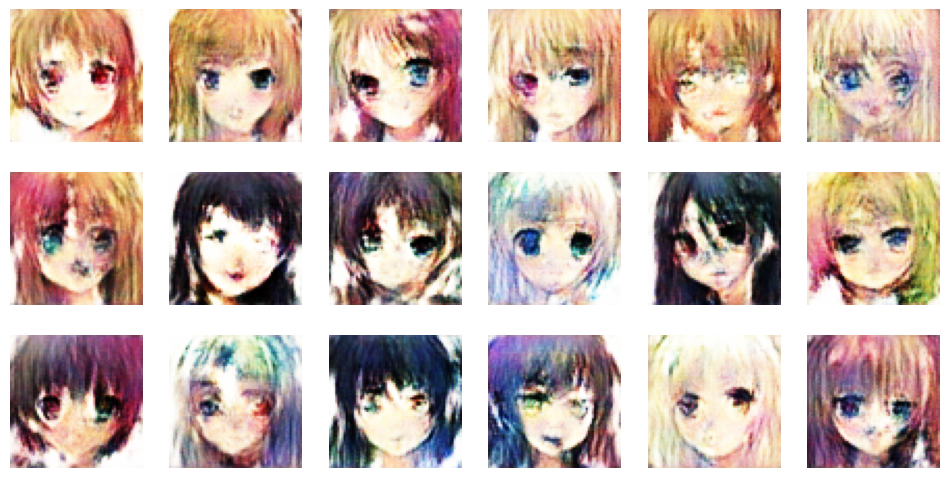

Saving checkpoint for epoch 30 at checkpoints/tensorflow/WGAN/ckpt-2
Time taken for epoch 30 is 49.54199695587158 sec

Start of epoch 31
current_learning_rate 0.000100
.............

In [ ]:
if not os.path.exists("ouput"):
  os.mkdir("output")

for epoch in range(CURRENT_EPOCH, EPOCHs + 1):
  #for each epoch get the startgin time, calc the lr decay and update the lr
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Using learning rate decay
    current_learning_rate = learning_rate_decay(current_learning_rate)
    print('current_learning_rate %f' % (current_learning_rate,))
    set_learning_rate(current_learning_rate)

    for step, (image) in enumerate(train_data): #for each batch
        current_batch_size = image.shape[0]
        # Train critic
        train_d_step(image, batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
        n_critic_count += 1
        if n_critic_count >= N_CRITIC:
            # Train g
            train_g_step(image, batch_size= tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
            n_critic_count = 0

        if step % 10 == 0:
            print ('.', end='')

    # clear notebook
    clear_output(wait=True)
    # Using a consistent sample so that the progress of the model is clearly visible.
    generate_and_save_images(generator, epoch, [sample_noise], figure_size=(12,6), subplot=(3,6), save=True, is_flatten=False)

    if epoch % SAVE_EVERY_N_EPOCH == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))

# Save at final epoch
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint for epoch {} at {}'.format(EPOCHs,
                                                        ckpt_save_path))
